<a href="https://colab.research.google.com/github/vicente-gonzalez-ruiz/medical_imaging/blob/main/notebooks/lena_ESRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Super Resolution using ESRGAN

Based on https://www.tensorflow.org/hub/tutorials/image_enhancing

This colab demonstrates use of TensorFlow Hub Module for Enhanced Super Resolution Generative Adversarial Network (*by Xintao Wang et.al.*) [[Paper](https://arxiv.org/pdf/1809.00219.pdf)] [[Code](https://github.com/captain-pool/GSOC/)]

for image enhancing. *(Preferrably bicubically downsampled images).*

Model trained on DIV2K Dataset (on bicubically downsampled images) on image patches of size 128 x 128.

**Preparing Environment**

In [2]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [3]:
#!wget "https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png" -O original.png
!wget "https://www.hpca.ual.es/~vruiz/images/lena.png" -O original.png

--2025-09-10 10:57:57--  https://www.hpca.ual.es/~vruiz/images/lena.png
Resolving www.hpca.ual.es (www.hpca.ual.es)... 150.214.150.42
Connecting to www.hpca.ual.es (www.hpca.ual.es)|150.214.150.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 512673 (501K) [image/png]
Saving to: ‘original.png’

original.png        100%[===================>] 500.66K   543KB/s    in 0.9s    

2025-09-10 10:57:59 (543 KB/s) - ‘original.png’ saved [512673/512673]



In [4]:
# Declaring Constants
IMAGE_PATH = "original.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

**Defining Helper Functions**

In [5]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [6]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

#### Performing Super Resolution of images loaded from path

In [7]:
hr_image = preprocess_image(IMAGE_PATH)

Saved as Original Image.jpg


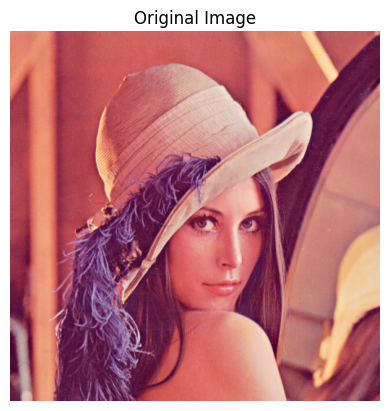

In [8]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [9]:
model = hub.load(SAVED_MODEL_PATH)

In [10]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 76.945497


Saved as Super Resolution.jpg


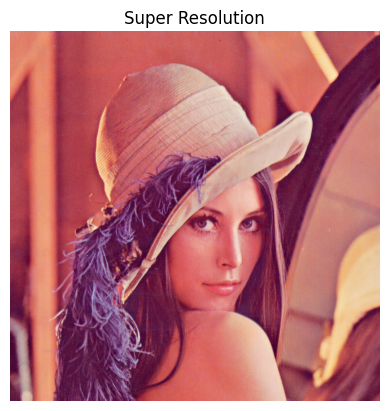

In [11]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

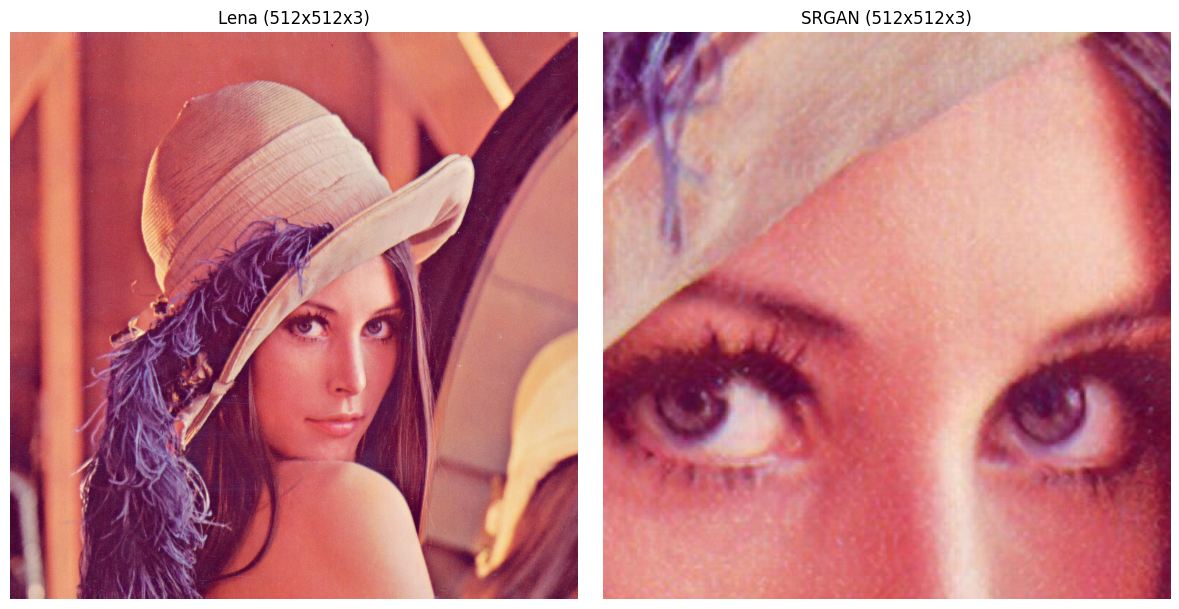

In [24]:
# Open the image using Pillow
img = Image.open("Super Resolution.jpg")

# Convert the image to a numpy array for easy slicing
img_np = np.array(img)

# Define the tile boundaries (example: the face of Lena)
# These coordinates are approximate and can be adjusted
top = 200 * 4
bottom = 300 * 4
left = 250 * 4
right = 350 * 4

tile = img_np[top:bottom, left:right, :]

# 2. Display the images horizontally
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # 1 row, 2 columns

# Display the original image in the first subplot
axes[0].imshow(img)
axes[0].set_title("Lena (512x512x3)")
axes[0].axis('off')

# Display the tile in the second subplot using bilinear interpolation
axes[1].imshow(tile,)
axes[1].set_title("ESRGAN (512x512x3)")
axes[1].axis('off')

plt.tight_layout() # Adjust layout to prevent overlapping
plt.savefig("../imgs/lena_ESRGAN.png", bbox_inches='tight')
plt.show()